In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import scipy.stats as sps
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm
from utils.beta import BetaMixture1D


In [7]:
def plot_insights(directories, mixture="beta", clip_min=0.01, clip_max=0.99, return_data=False):
    if isinstance(directories, str):
        directories = [directories]

    all_results = {}
    single_dir_data_for_hist = {}

    for directory in directories:
        import os
        if not os.path.exists(f"outputs/{directory}/losses.npy"):
            print(f"Directory {directory} does not exist or does not contain the required files.")
            continue
                              
        data = np.load(f"outputs/{directory}/losses.npy")
        epochs = 0
        for i in range(data.shape[0]):
            if np.count_nonzero(data[i]) > 0:
                epochs += 1
        data = data[:epochs, :]

        true_labels = np.load(f'outputs/{directory}/true_labels.npy')
        corrupted_labels = np.load(f'outputs/{directory}/corrupted_labels.npy')
        labels_history = np.load(f'outputs/{directory}/labels_history.npy')[:epochs, :]
        val_accuracies = np.load(f'outputs/{directory}/val_accuracies.npy')[:epochs]
        train_accuracies = np.load(f'outputs/{directory}/train_accuracies.npy')[:epochs]
        train_predictions = np.load(f'outputs/{directory}/train_predictions.npy')[:epochs, :]
        is_corrupted_initial = true_labels != corrupted_labels
        is_corrupted = labels_history != true_labels[None, :]

        aucs = []
        intersections = []
        gmm_diffs = []
        corr_pred_precisions = []
        corr_pred_recalls = []

        corrupted_fraction = (labels_history == true_labels).sum(axis=1) / labels_history.shape[1]
        corrupted_fraction = 1 - corrupted_fraction

        if len(directories) == 1:
            single_dir_data_for_hist['data'] = data
            single_dir_data_for_hist['epochs'] = epochs
            single_dir_data_for_hist['is_corrupted'] = is_corrupted
            
        distributions = []

        for epoch in tqdm(range(epochs), desc=f"Processing {directory}", leave=False):
            scaled_data = np.clip(data[epoch, :], np.quantile(data[epoch, :], clip_min), np.quantile(data[epoch, :], clip_max))
            if mixture == "beta":
                scaled_data = (scaled_data - np.min(scaled_data)) / (np.max(scaled_data) - np.min(scaled_data))
            else:
                std_val = np.std(scaled_data)
                if std_val > 1e-9:
                    scaled_data = (scaled_data - np.mean(scaled_data)) / std_val
                else:
                    scaled_data = scaled_data - np.mean(scaled_data)

            clipped_data = scaled_data
            min_clip, max_clip = min(clipped_data), max(clipped_data)
            if max_clip <= min_clip:
                 bins = np.array([min_clip, min_clip + 1e-6])
            else:
                 bins = np.linspace(min_clip, max_clip, 50)

            h_clean = np.histogram(clipped_data[~is_corrupted[epoch]], bins=bins, density=True)[0]
            h_corrupted = np.histogram(clipped_data[is_corrupted[epoch]], bins=bins, density=True)[0]
            intersection = np.sum(np.minimum(h_clean, h_corrupted))
            sum_h_clean = np.sum(h_clean)
            intersection = intersection / sum_h_clean if sum_h_clean > 1e-9 else np.nan
            intersections.append(intersection)

            no_outliers_data = scaled_data[(scaled_data < np.quantile(scaled_data, clip_max) ) & (scaled_data > np.quantile(scaled_data, clip_min))]

            gmm_intersection = np.nan
            if mixture == "beta": 
                gmm = BetaMixture1D(max_iters=100)
            else:
                gmm = GaussianMixture(n_components=2, covariance_type='diag')
            gmm.fit(no_outliers_data.reshape(-1, 1))
            if mixture == "beta":
                pdf1 = gmm.get_distribution(0).pdf(bins)
                pdf2 = gmm.get_distribution(1).pdf(bins)
                distributions.append((gmm.get_distribution(0), gmm.get_distribution(1)))
            else:
                covs = gmm.covariances_
                mu1, sigma1 = gmm.means_[0][0], np.sqrt(covs[0][0])
                mu2, sigma2 = gmm.means_[1][0], np.sqrt(covs[1][0])
                if mu1 > mu2:
                    mu1, sigma1, mu2, sigma2 = mu2, sigma2, mu1, sigma1

                pdf1 = sps.norm(mu1, sigma1).pdf(bins)
                pdf2 = sps.norm(mu2, sigma2).pdf(bins)
                distributions.append((sps.norm(mu1, sigma1), sps.norm(mu2, sigma2)))
            
            proba_corrupted = gmm.predict_proba(scaled_data.reshape(-1, 1))[:, 1]
            proba_corrupted = np.nan_to_num(proba_corrupted, nan=0.0)
                
            from sklearn.metrics import roc_auc_score
            roc_auc = roc_auc_score(is_corrupted_initial, proba_corrupted)
            if roc_auc < 0.5:
                roc_auc = roc_auc_score(is_corrupted_initial, 1 - proba_corrupted)
            aucs.append(roc_auc)

            
            sum_pdf1 = np.sum(pdf1)
            gmm_intersection = np.sum(np.minimum(pdf1, pdf2)) / sum_pdf1 if sum_pdf1 > 1e-9 else np.nan

            gmm_diffs.append(gmm_intersection)

        avg_loss_corrupted_list = []
        avg_loss_clean_list = []
        for ep in range(epochs):
             clean_losses_ep = data[ep, ~is_corrupted[ep]]
             corrupted_losses_ep = data[ep, is_corrupted[ep]]
             avg_loss_clean_list.append(np.mean(clean_losses_ep) if clean_losses_ep.size > 0 else np.nan)
             avg_loss_corrupted_list.append(np.mean(corrupted_losses_ep) if corrupted_losses_ep.size > 0 else np.nan)


        initial_is_corrupted = is_corrupted[0]
        sum_initial_corrupted = initial_is_corrupted.sum()
        if sum_initial_corrupted > 0:
            misclassified = (
                train_predictions == corrupted_labels.reshape(1, -1)
            )[:, initial_is_corrupted].sum(axis=1) / len(initial_is_corrupted)
            correct = (
                train_predictions == true_labels.reshape(1, -1)
            ).sum(axis=1) / len(initial_is_corrupted)
            incorrect = (
                (train_predictions != true_labels.reshape(1, -1)) & (train_predictions != corrupted_labels.reshape(1, -1))
            ).sum(axis=1) / len(initial_is_corrupted)
        else:
            nan_array = np.full(epochs, np.nan)
            misclassified, correct, incorrect = nan_array, nan_array, nan_array


        all_results[directory] = {
            'val_accuracies': val_accuracies,
            'corrupted_fraction': corrupted_fraction,
            'avg_loss_corrupted': np.array(avg_loss_corrupted_list),
            'avg_loss_clean': np.array(avg_loss_clean_list),
            'gmm_diffs': np.array(gmm_diffs),
            'train_accuracies': train_accuracies,
            'misclassified': misclassified,
            'correct': correct,
            'incorrect': incorrect,
            'aucs': np.array(aucs),
            'intersections': np.array(intersections),
            'corr_pred_precisions': np.array(corr_pred_precisions),
            'corr_pred_recalls': np.array(corr_pred_recalls),
            'distributions': distributions,
            'losses': data,
            'is_corrupted': is_corrupted_initial,
        }
        
    if return_data:
        return all_results

    if len(directories) == 1:
        directory = directories[0]
        data = single_dir_data_for_hist['data']
        epochs = single_dir_data_for_hist['epochs']
        is_corrupted = single_dir_data_for_hist['is_corrupted']

        k, m = 5, 4
        fig_hist, ax_hist = plt.subplots(k, m, figsize=(12, 8))
        handles, labels = None, None
        for i in range(k):
            for j in range(m):
                n = i * m + j
                epoch = min(int(n * (epochs / (k * m))), epochs - 1)
                clipped_data = data[epoch, :].copy()
                
                clipped_data = np.clip(
                    clipped_data,
                    np.quantile(clipped_data, clip_min),
                    np.quantile(clipped_data, clip_max)
                )
                if mixture == "beta":
                    clipped_data = (clipped_data - np.min(clipped_data)) / (np.max(clipped_data) - np.min(clipped_data))
                else:
                    std_val = np.std(clipped_data)
                    if std_val > 1e-9:
                        clipped_data = (clipped_data - np.mean(clipped_data)) / std_val
                    else:
                        clipped_data = clipped_data - np.mean(clipped_data)


                bins = np.linspace(min(clipped_data), max(clipped_data), 50)

                h1, _, _ = ax_hist[i, j].hist(clipped_data[~is_corrupted[epoch]], bins=bins, alpha=0.5, label='Clean Labels', density=True)
                h2, _, _ = ax_hist[i, j].hist(clipped_data[is_corrupted[epoch]], bins=bins, alpha=0.5, label='Corrupted Labels', density=True)
                ax_hist[i, j].set_title(f'Epoch {epoch}')

                all_h = np.concatenate((h1, h2))
                if all_h.size > 0:
                    q4 = np.quantile(all_h, 0.75)
                    q1 = np.quantile(all_h, 0.25)
                    iqr = q4 - q1
                    upper_bound = q4 + 10 * iqr
                    max_h = max(h1.max(), h2.max()) if h1.size > 0 and h2.size > 0 else (h1.max() if h1.size > 0 else (h2.max() if h2.size > 0 else 0))
                    ax_hist[i, j].set_ylim(0, min(upper_bound, max_h * 1.1))
                else:
                    ax_hist[i, j].set_ylim(0, 1)

                if i == 0 and j == 0:
                    handles, labels = ax_hist[i, j].get_legend_handles_labels()                

                x = np.linspace(min(clipped_data), max(clipped_data), 100)
                pdf1 = distributions[epoch][0].pdf(x)
                pdf2 = distributions[epoch][1].pdf(x)
                
                ax_hist[i, j].plot(x, pdf1, color='blue')
                ax_hist[i, j].plot(x, pdf2, color='red')
                

        if handles and labels:
             fig_hist.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.01))

        plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.95])
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        plt.show()


    _, ax = plt.subplots(4, 2, figsize=(10, 13))

    for dir_name, results in all_results.items():
        ax[0, 0].plot(results['val_accuracies'], label=dir_name)
        ax[0, 1].plot(results['corrupted_fraction'], label=dir_name)
        ax[1, 0].plot(results['avg_loss_corrupted'], label=f'{dir_name} Corrupted')
        ax[1, 0].plot(results['avg_loss_clean'], label=f'{dir_name} Clean', linestyle='--')
        ax[1, 1].plot(results['gmm_diffs'], label=dir_name)
        ax[2, 0].plot(results['train_accuracies'], label=dir_name)
        ax[2, 1].plot(results['misclassified'], label=f'{dir_name} Memorized')
        ax[2, 1].plot(results['correct'], label=f'{dir_name} Correct', linestyle='--')
        ax[2, 1].plot(results['incorrect'], label=f'{dir_name} Incorrect', linestyle=':')
        ax[3, 0].plot(results['aucs'], label=dir_name)
        ax[3, 1].plot(results['intersections'], label=dir_name)

    ax[0, 0].set_title('Validation Accuracy')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Accuracy')
    if len(directories) > 1: ax[0, 0].legend()

    ax[0, 1].set_title('Corrupted Fraction')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Fraction')
    ax[0, 1].set_yticks(np.arange(
        0,
        np.max([results['corrupted_fraction'].max() for results in all_results.values()]) + 0.05,
        step=0.05
    ))
    if len(directories) > 1: ax[0, 1].legend()

    ax[1, 0].set_title('Average Loss')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend(fontsize='small')

    ax[1, 1].set_title('GMM Intersection')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Intersection')
    if len(directories) > 1: ax[1, 1].legend()

    ax[2, 0].set_title('Train Accuracy')
    ax[2, 0].set_xlabel('Epoch')
    ax[2, 0].set_ylabel('Accuracy')
    if len(directories) > 1: ax[2, 0].legend()

    ax[2, 1].set_title('Train Predictions on corrupted data')
    ax[2, 1].set_xlabel('Epoch')
    ax[2, 1].set_ylabel('Fraction')
    ax[2, 1].legend(fontsize='small')

    ax[3, 0].set_title('ROC AUC')
    ax[3, 0].set_ylabel('AUC')
    ax[3, 0].set_xlabel('Epoch')
    if len(directories) > 1: ax[3, 0].legend()

    ax[3, 1].set_title('Intersection of Histograms')
    ax[3, 1].set_ylabel('Intersection')
    ax[3, 1].set_xlabel('Epoch')
    if len(directories) > 1: ax[3, 1].legend()

    plt.tight_layout()
    plt.show()

## CIFAR

In [ ]:
plot_insights('adamw_resnet18_cifar_ce_unif_0.4_42', clip_min=0, clip_max=0.999, mixture='beta')

Processing adversarial_minmin_resnet18_cifar_ce_flip_0.4_42:   0%|          | 0/265 [00:00<?, ?it/s]

/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encounter

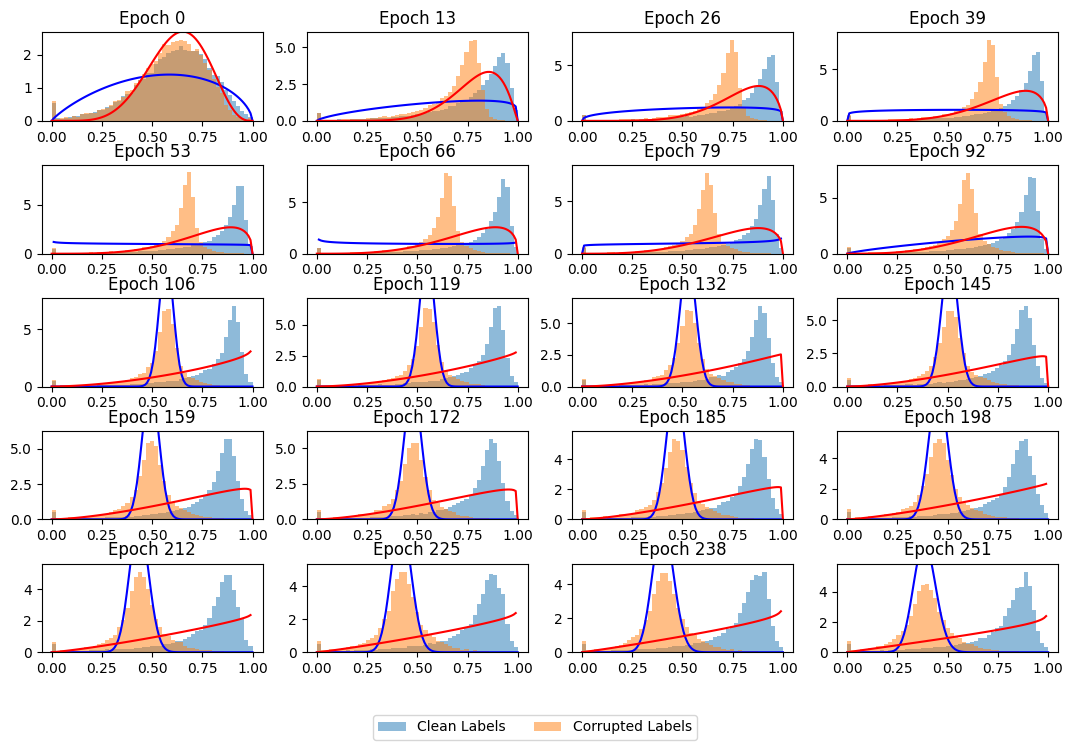

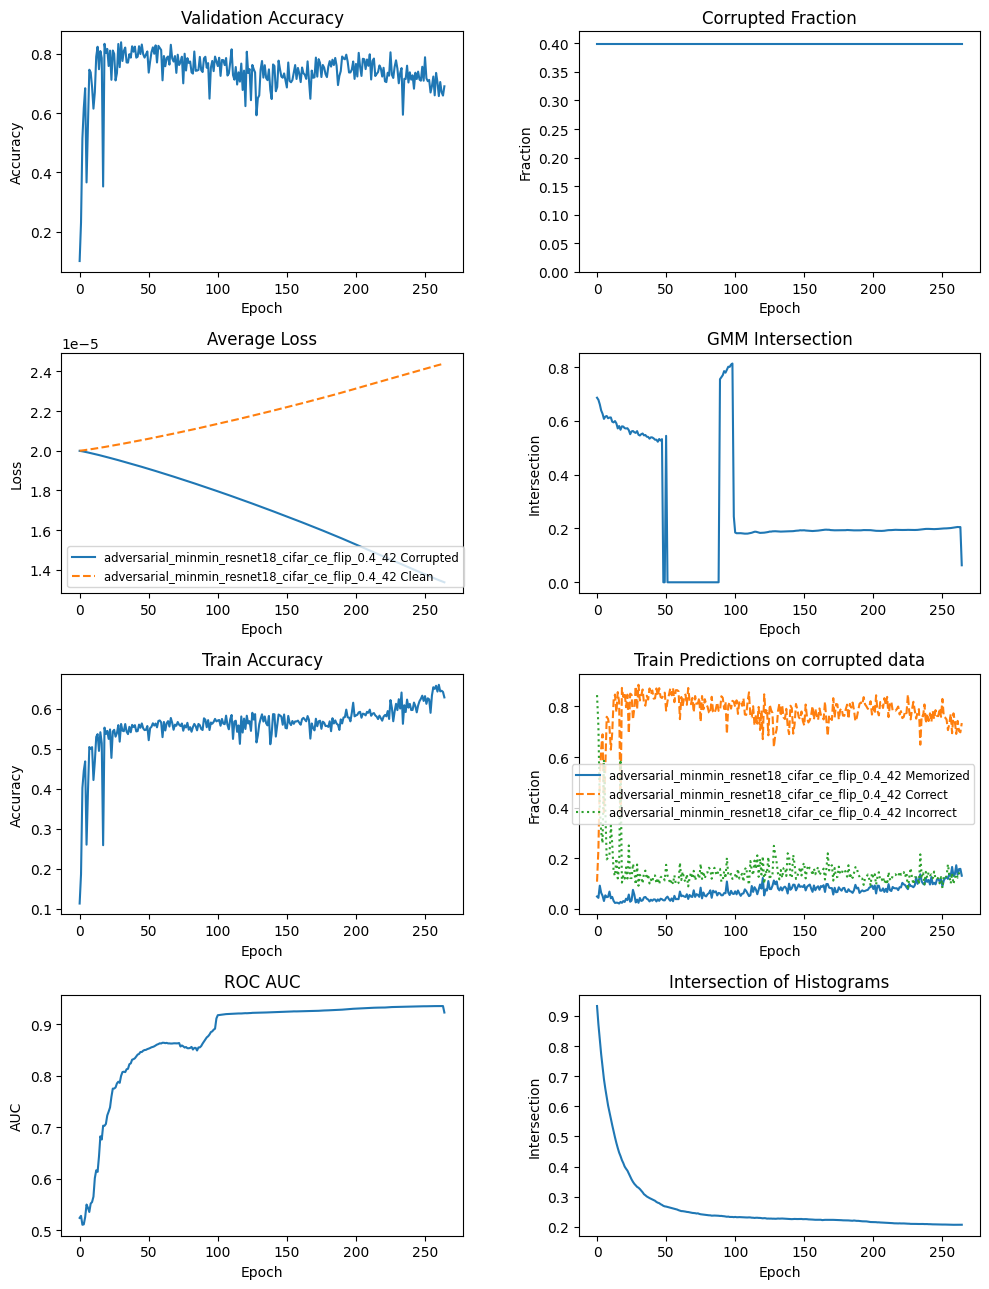

In [6]:
plot_insights('adversarial_minmin_resnet18_cifar_ce_flip_0.4_42', clip_min=0.01, clip_max=0.999, mixture='beta')

Processing adversarial_maxmin_resnet18_cifar_ce_unif_0.8_42:   0%|          | 0/104 [00:00<?, ?it/s]

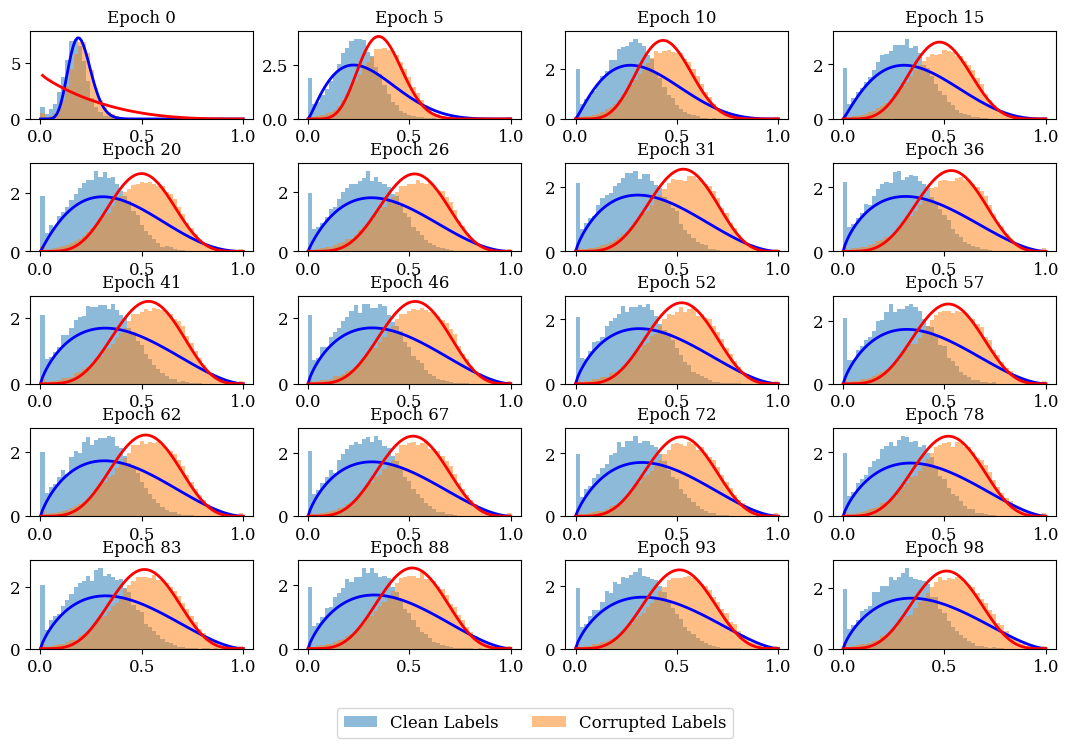

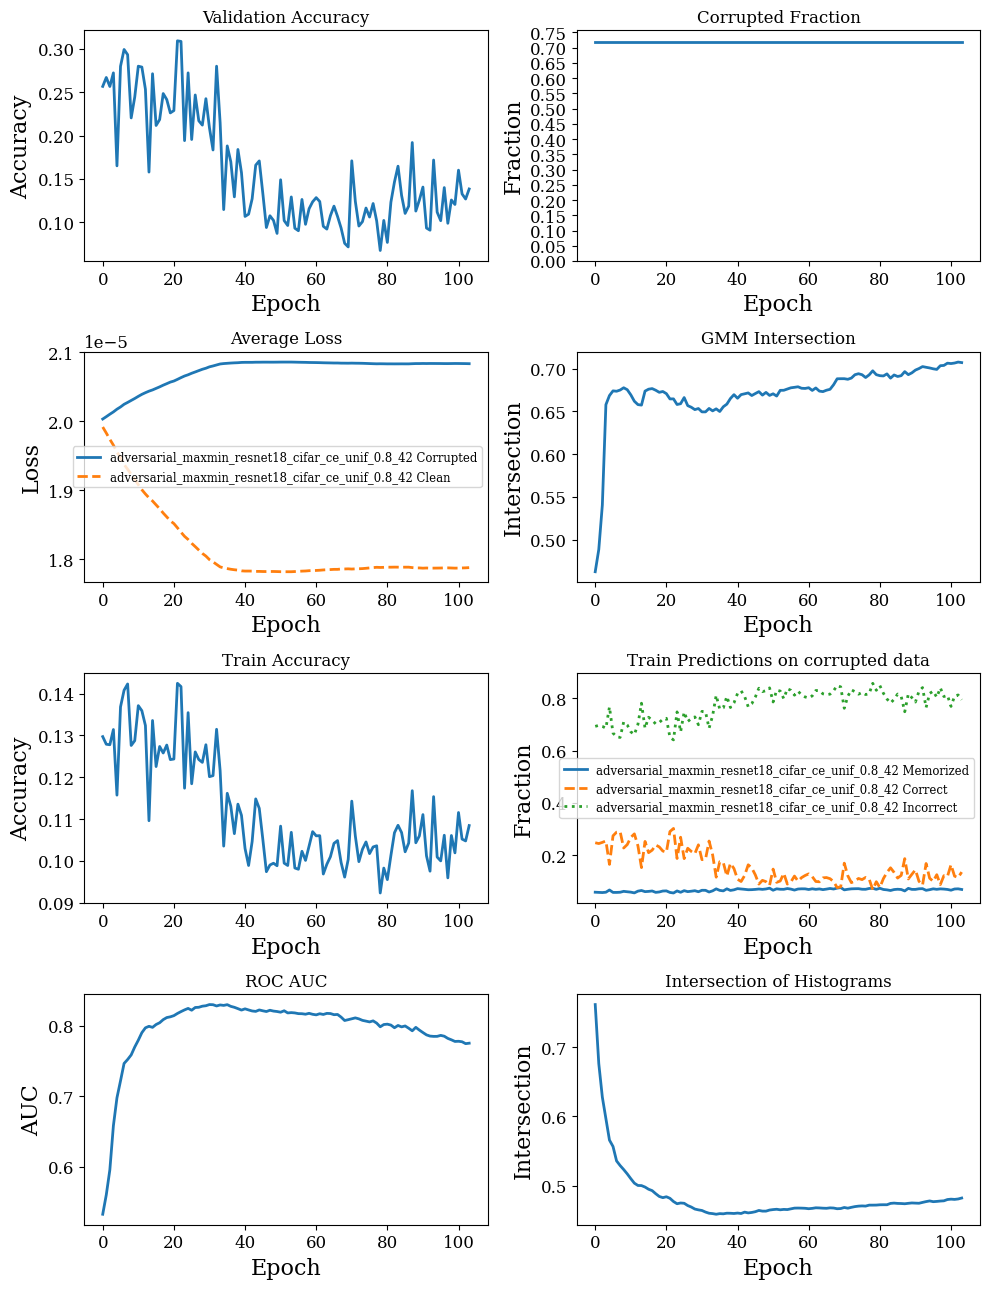

In [16]:
plot_insights('adversarial_maxmin_resnet18_cifar_ce_unif_0.8_42', clip_min=0.01, clip_max=0.999, mixture='beta')

In [10]:
from warnings import filterwarnings
filterwarnings("ignore")

all_data = plot_insights(
    [
        'adamw_resnet18_cifar_ce_flip_0.4_42',
        'adamw_resnet18_cifar_ce_unif_0.4_42',
        'adamw_resnet18_cifar_ce_unif_0.8_42',
        'adamw_resnet34_cifar_ce_unif_0.8_42',
        'adversarial_minmin_resnet18_cifar_ce_flip_0.4_42',
        'adversarial_minmin_resnet18_cifar_ce_unif_0.4_42',
        'adversarial_minmin_resnet18_cifar_ce_unif_0.8_42',
        'adversarial_minmin_resnet34_cifar_ce_unif_0.8_42',
        'adversarial_maxmin_resnet18_cifar_ce_unif_0.8_42',
    ],
    clip_min=0.01,
    clip_max=0.99,
    mixture='beta',
    return_data=True
)

Processing adamw_resnet18_cifar_ce_flip_0.4_42:   0%|          | 0/133 [00:00<?, ?it/s]

Processing adamw_resnet18_cifar_ce_unif_0.4_42:   0%|          | 0/112 [00:00<?, ?it/s]

Processing adamw_resnet18_cifar_ce_unif_0.8_42:   0%|          | 0/100 [00:00<?, ?it/s]

Processing adamw_resnet34_cifar_ce_unif_0.8_42:   0%|          | 0/102 [00:00<?, ?it/s]

Processing adversarial_minmin_resnet18_cifar_ce_flip_0.4_42:   0%|          | 0/265 [00:00<?, ?it/s]

Processing adversarial_minmin_resnet18_cifar_ce_unif_0.4_42:   0%|          | 0/192 [00:00<?, ?it/s]

Processing adversarial_minmin_resnet18_cifar_ce_unif_0.8_42:   0%|          | 0/112 [00:00<?, ?it/s]

Processing adversarial_minmin_resnet34_cifar_ce_unif_0.8_42:   0%|          | 0/100 [00:00<?, ?it/s]

Processing adversarial_maxmin_resnet18_cifar_ce_unif_0.8_42:   0%|          | 0/104 [00:00<?, ?it/s]

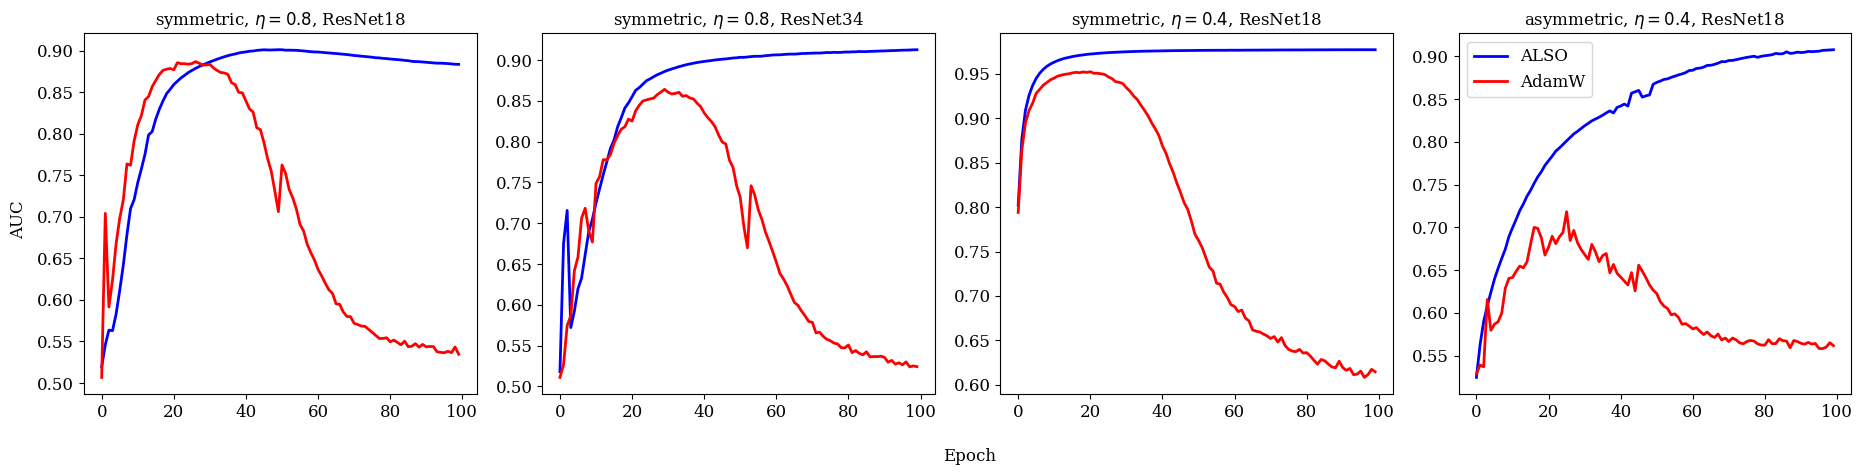

In [78]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 12#24
plt.rcParams['ytick.labelsize'] = 12#24
plt.rcParams['legend.fontsize'] = 12#24
plt.rcParams['axes.labelsize'] = 16

comparisons = [
    ('adversarial_minmin_resnet18_cifar_ce_unif_0.8_42', 'adamw_resnet18_cifar_ce_unif_0.8_42'),
    ('adversarial_minmin_resnet34_cifar_ce_unif_0.8_42', 'adamw_resnet34_cifar_ce_unif_0.8_42'),
    ('adversarial_minmin_resnet18_cifar_ce_unif_0.4_42', 'adamw_resnet18_cifar_ce_unif_0.4_42'),
    ('adversarial_minmin_resnet18_cifar_ce_flip_0.4_42', 'adamw_resnet18_cifar_ce_flip_0.4_42'),
]

titles = [
    'symmetric, $\\eta=0.8$, ResNet18',
    'symmetric, $\\eta=0.8$, ResNet34',
    'symmetric, $\\eta=0.4$, ResNet18',
    'asymmetric, $\\eta=0.4$, ResNet18',
]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, (p1, p2) in enumerate(comparisons):
    aucs1 = all_data[p1]['aucs'][:100]
    aucs2 = all_data[p2]['aucs'][:100]

    ax[i].plot(aucs1, label='ALSO', color='blue')
    ax[i].plot(aucs2, label='AdamW', color='red')
    ax[i].set_title(titles[i])
    
fig.supxlabel('Epoch')
fig.supylabel('AUC')
plt.tight_layout(rect=[0.01, 0.005, 0.95, 0.95])

plt.savefig('../docs/figures/adam_vs_also.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

Processing adamw_resnet18_cifar_ce_unif_0.8_42:   0%|          | 0/100 [00:00<?, ?it/s]

/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encounter

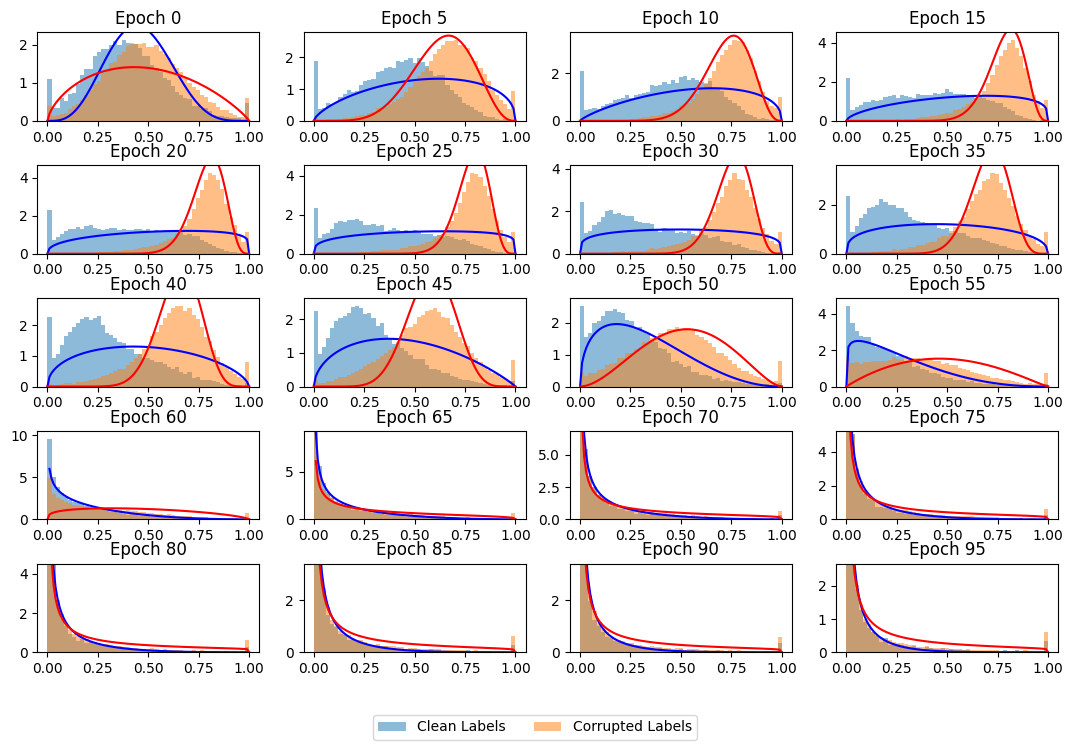

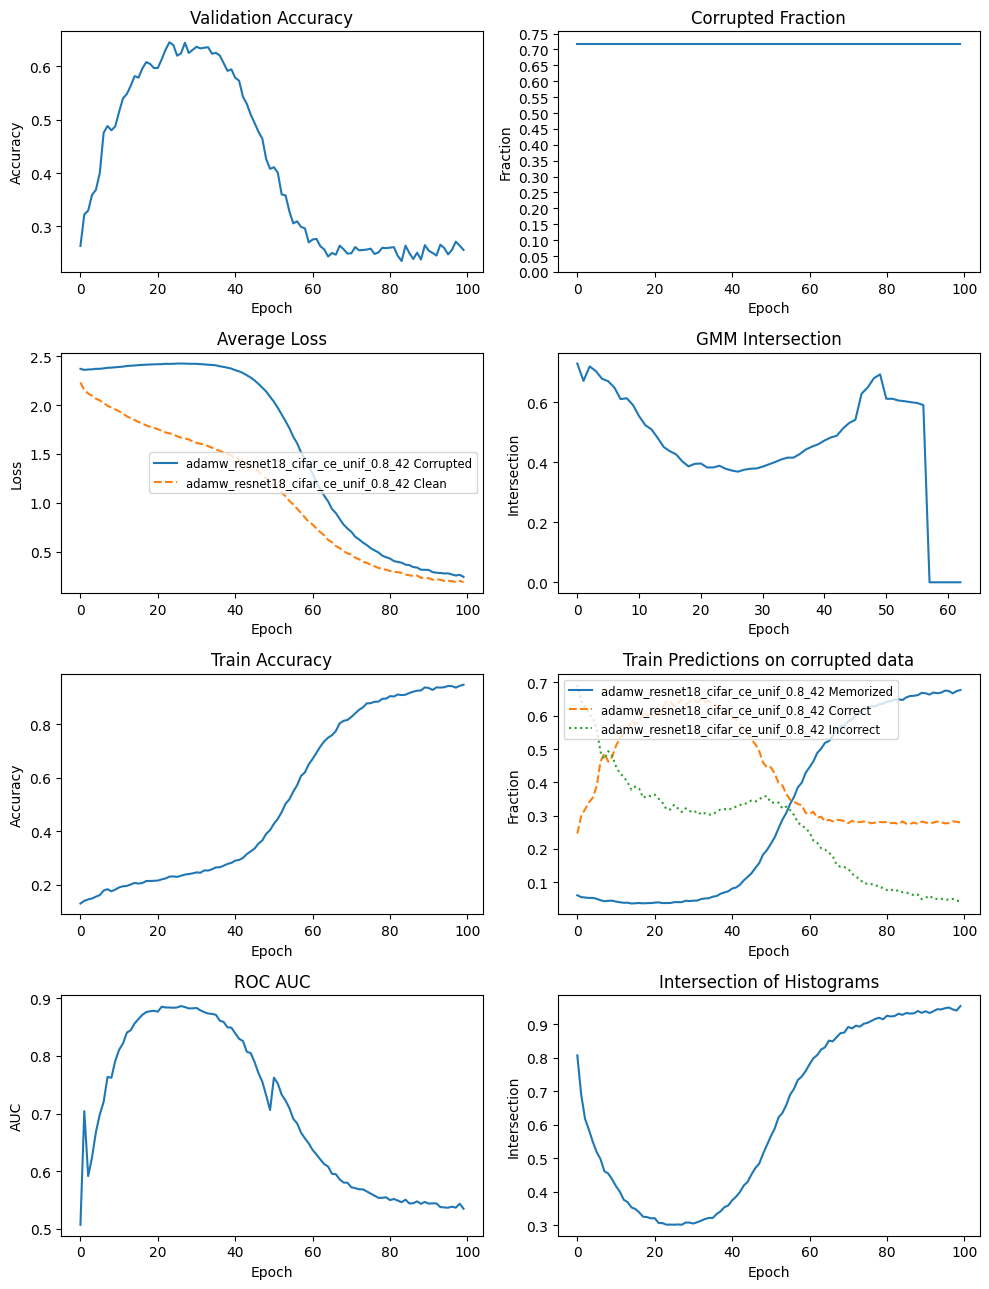

In [6]:
plot_insights('adamw_resnet18_cifar_ce_unif_0.8_42', mixture='beta')

Processing adversarial_minmin_resnet18_cifar_ce_unif_0.8_42:   0%|          | 0/112 [00:00<?, ?it/s]

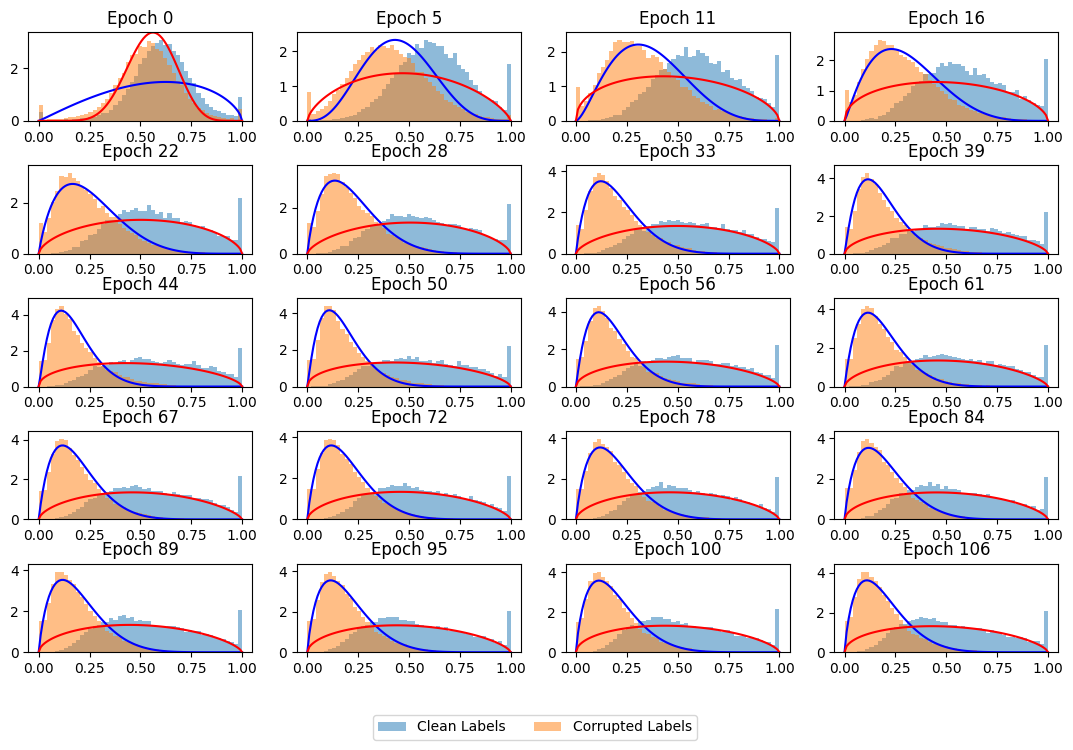

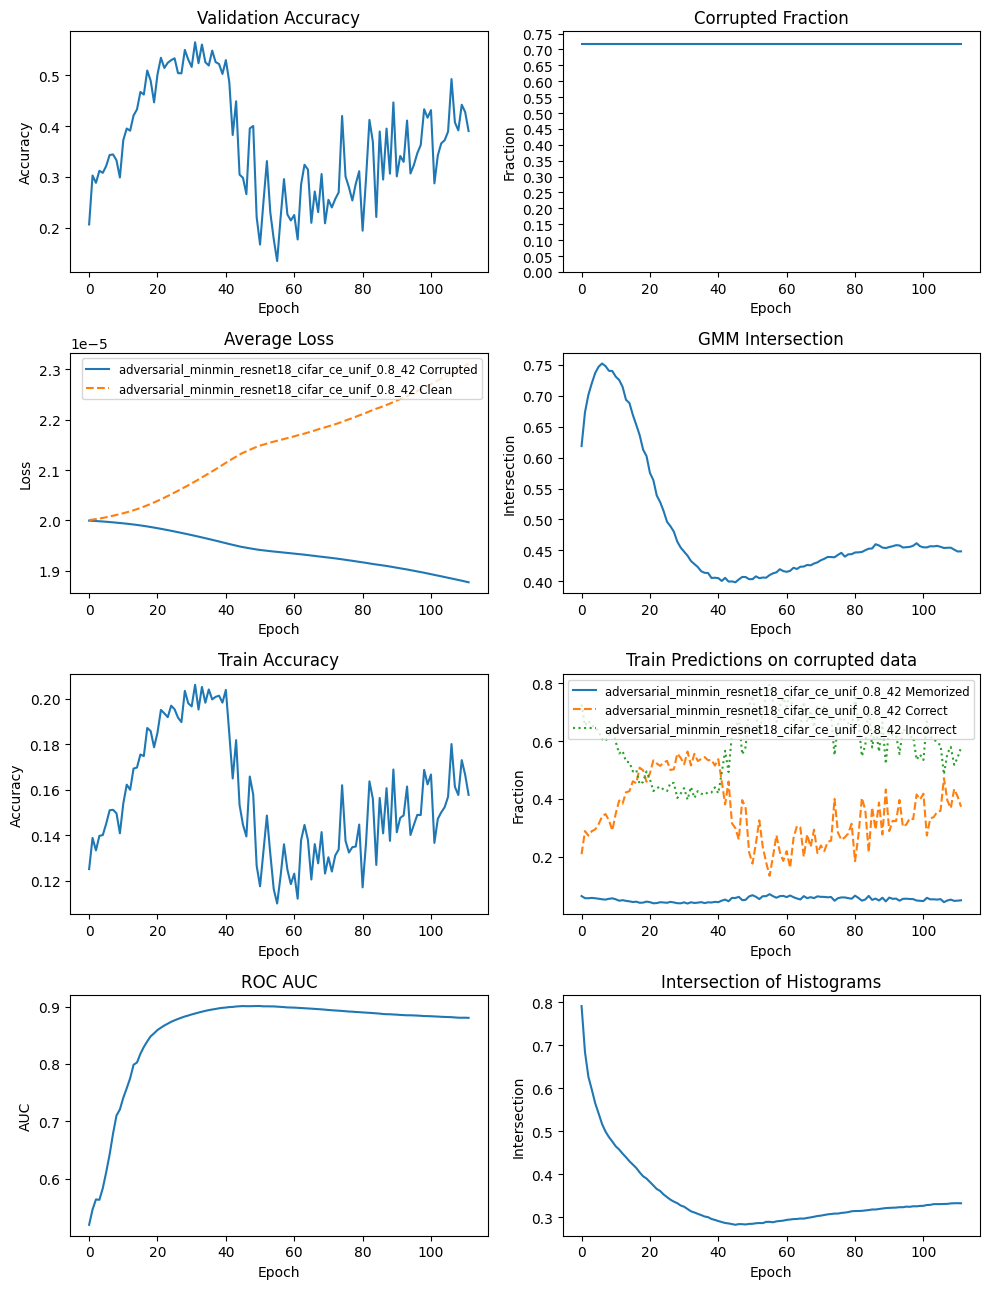

In [7]:
plot_insights('adversarial_minmin_resnet18_cifar_ce_unif_0.8_42', mixture='beta')

Processing adversarial_minmin_resnet18_cifar_ce_unif_0.4_42:   0%|          | 0/192 [00:00<?, ?it/s]

/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encounter

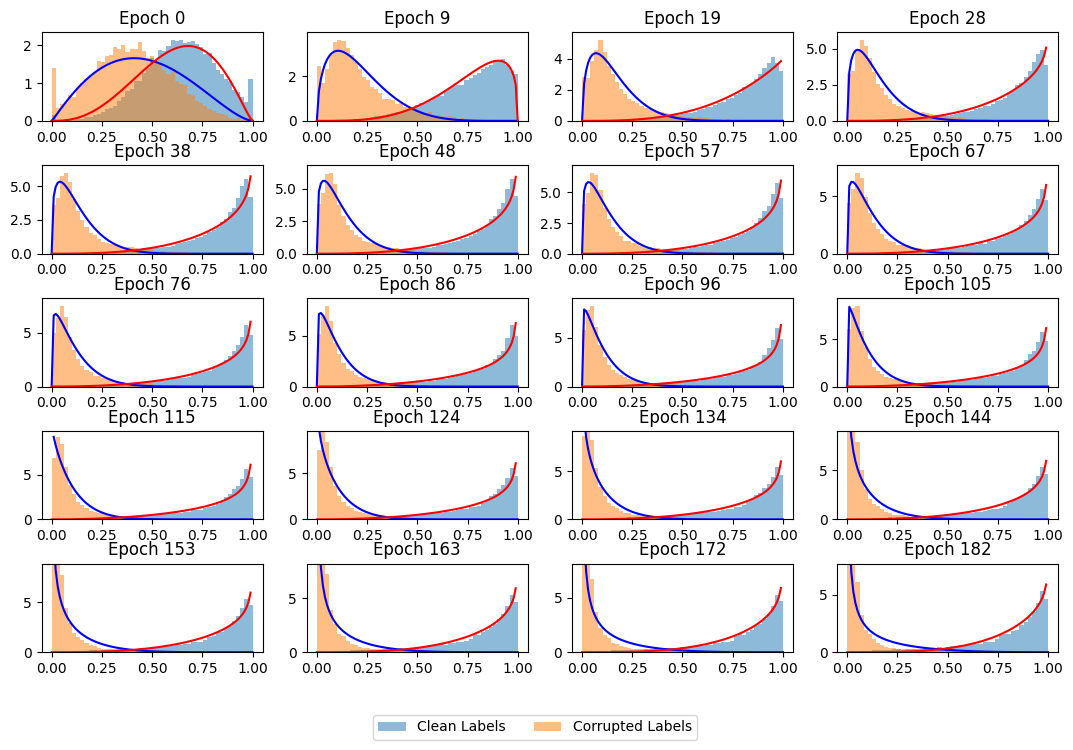

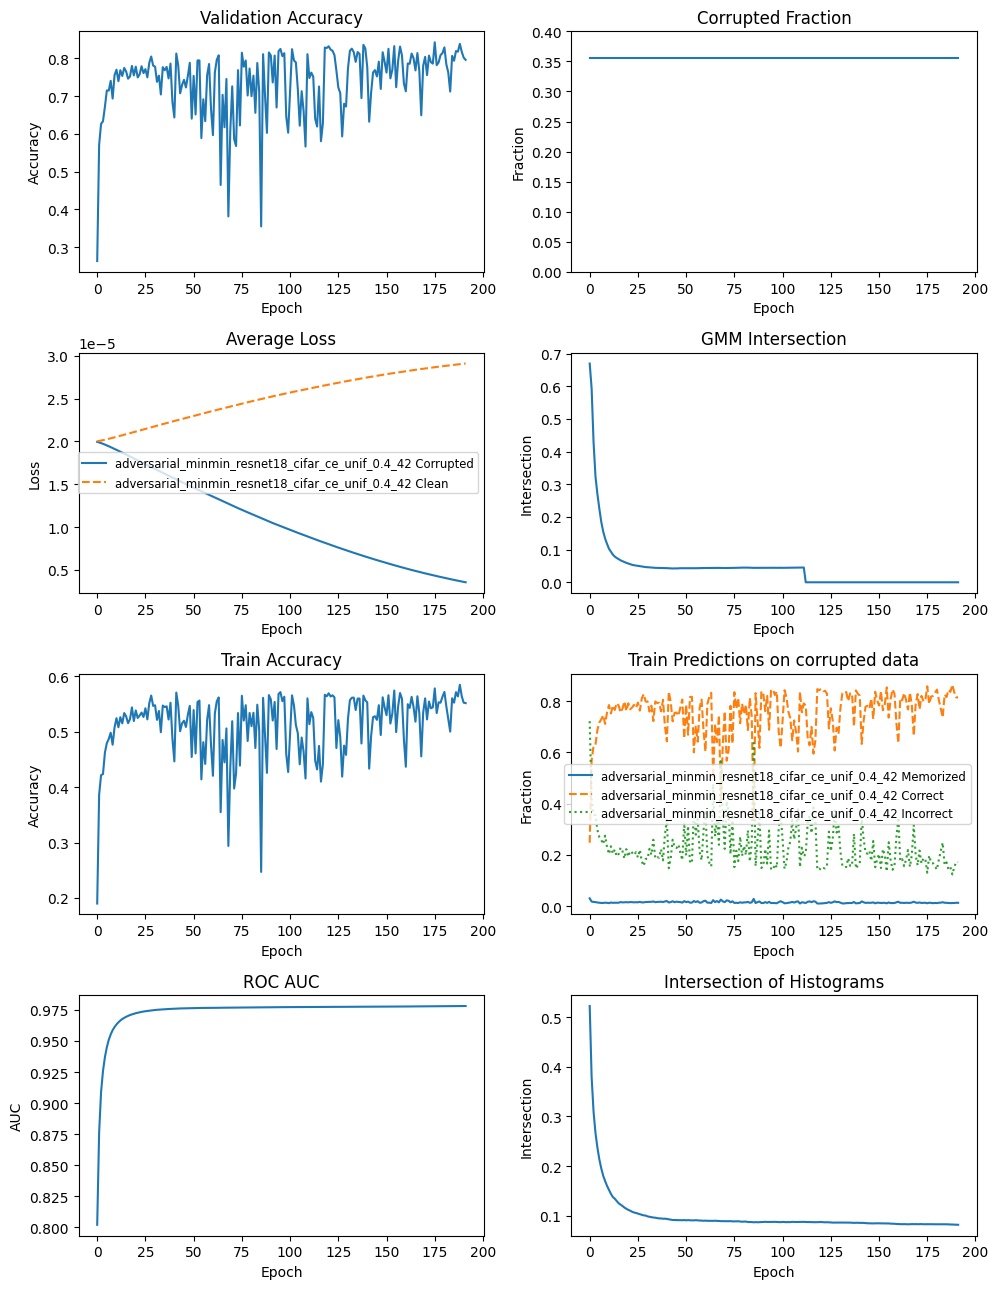

In [8]:
plot_insights('adversarial_minmin_resnet18_cifar_ce_unif_0.4_42', mixture='beta')

Processing sgd_resnet18_cifar_ce_unif_0.8_42:   0%|          | 0/103 [00:00<?, ?it/s]

/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encountered in divide
  return self.weighted_likelihood(x, y) / (self.probability(x) + self.eps_nan)
/workspace/2025-Project-175/code/utils/beta.py:54: RuntimeWarning: invalid value encounter

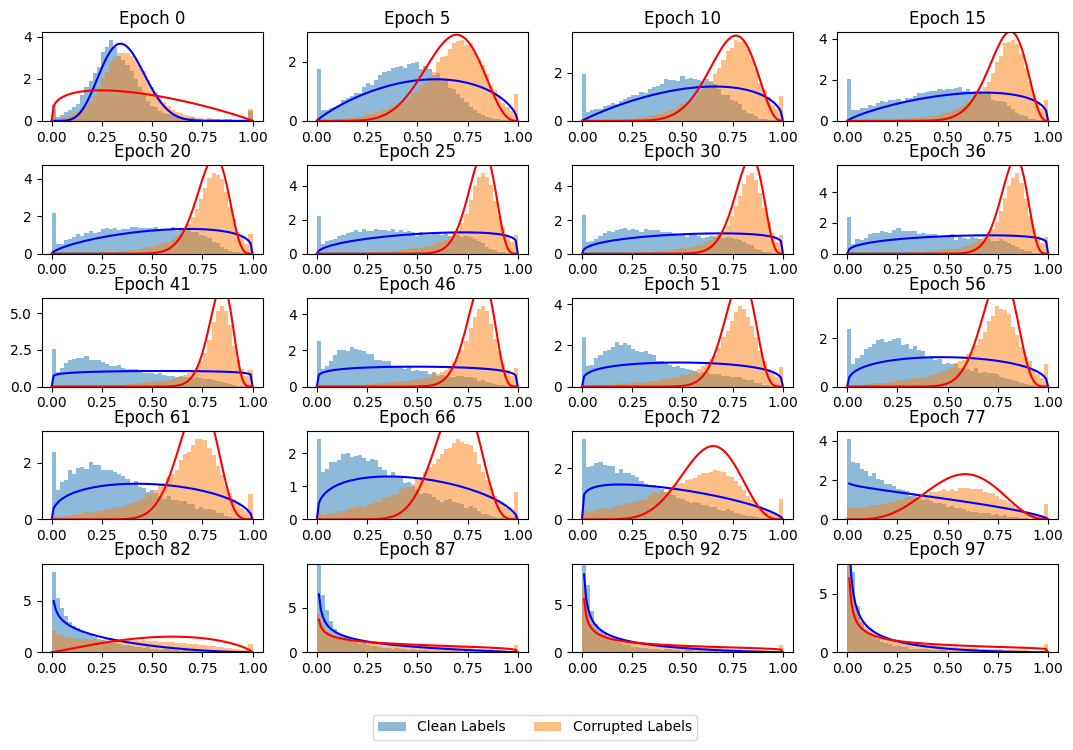

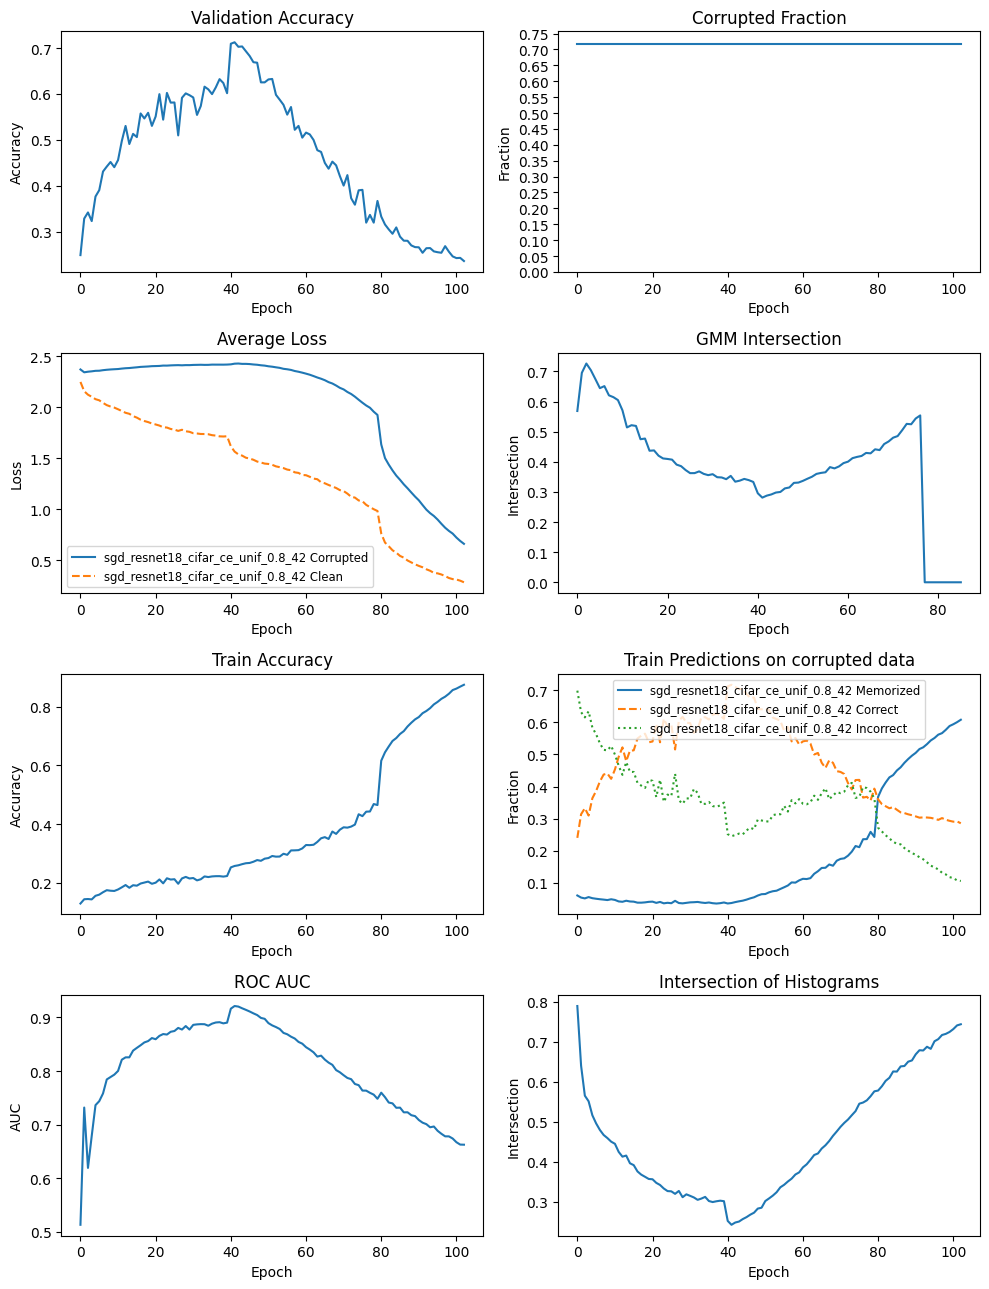

In [12]:
plot_insights('sgd_resnet18_cifar_ce_unif_0.8_42', mixture='beta')

Processing adamw_unif_resnet34_weights:   0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipykernel_627725/2431876221.py:97: RuntimeWarning: invalid value encountered in scalar divide
  gmm_intersection = np.sum(np.minimum(pdf1, pdf2)) / sum_pdf1 if sum_pdf1 > 1e-9 else np.nan


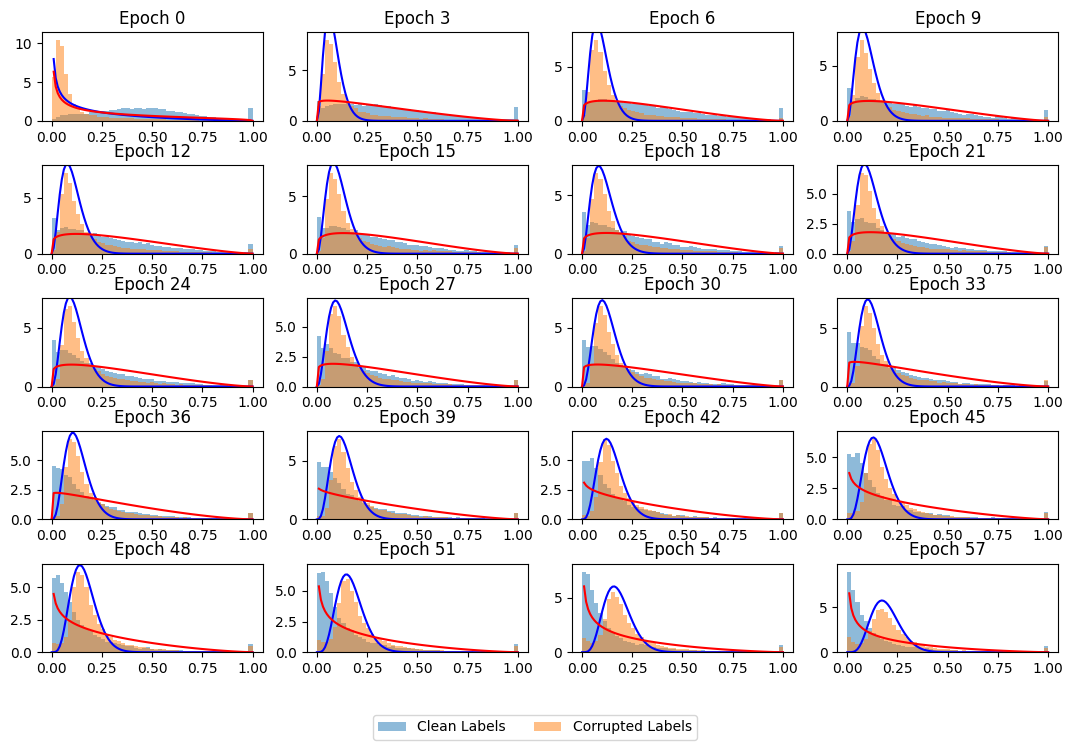

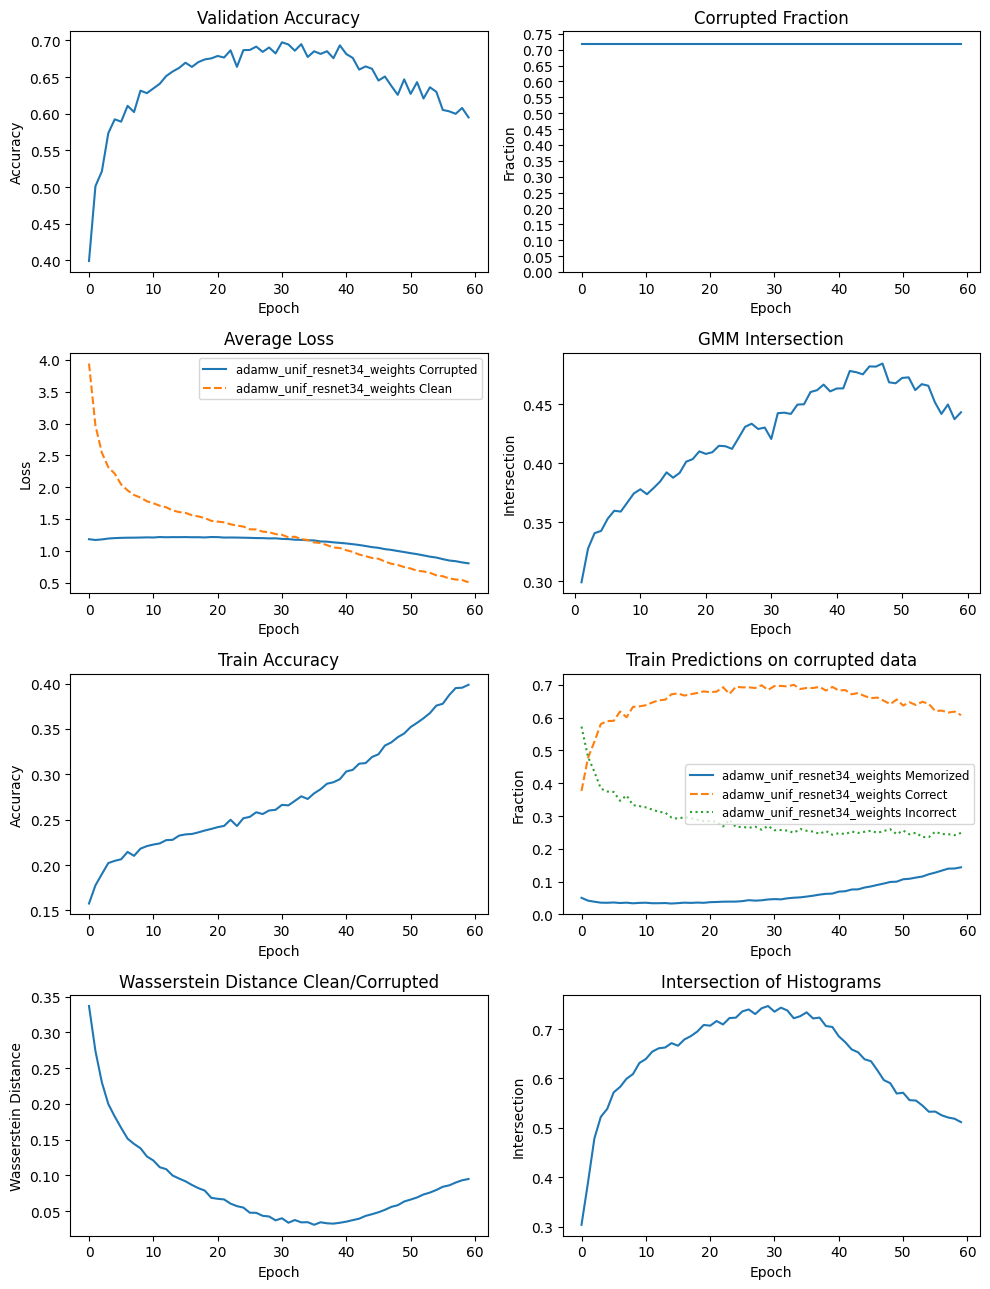

In [3]:
plot_insights('adamw_unif_resnet34_weights')

Processing minmin_unif_base:   0%|          | 0/58 [00:00<?, ?it/s]

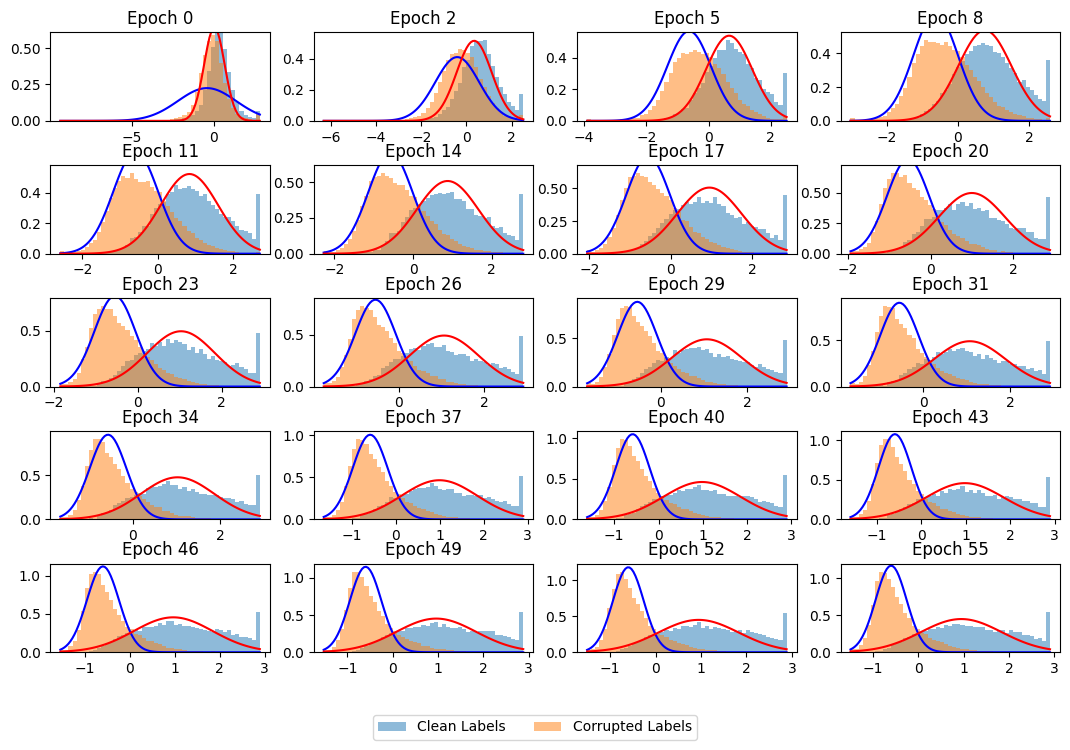

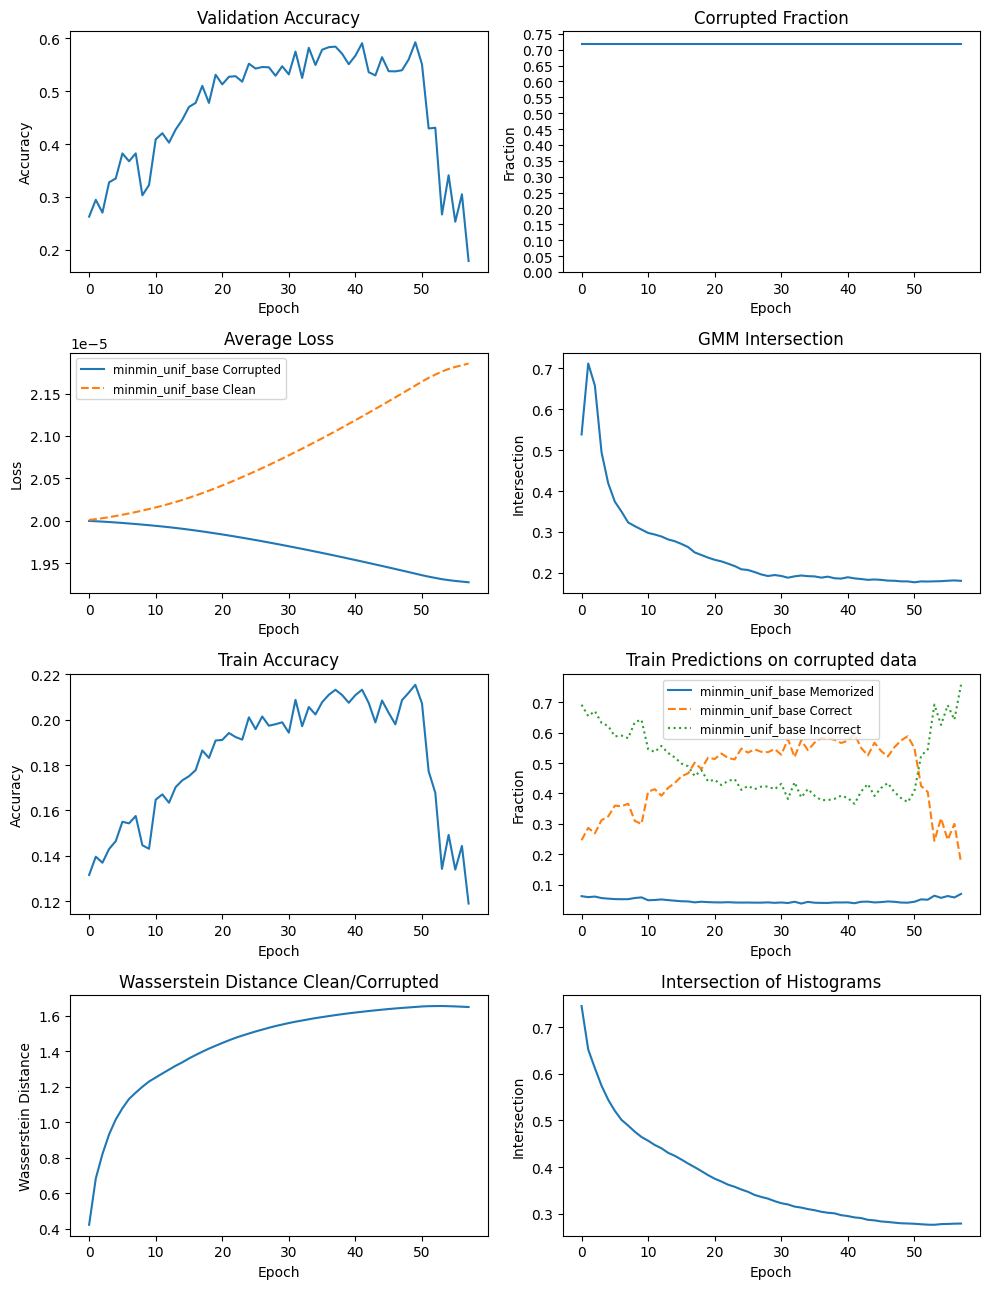

In [116]:
plot_insights('minmin_unif_base', mixture='gmm', clip_min=0.001, clip_max=0.99)

Processing adamw_unif_resnet34_base:   0%|          | 0/50 [00:00<?, ?it/s]

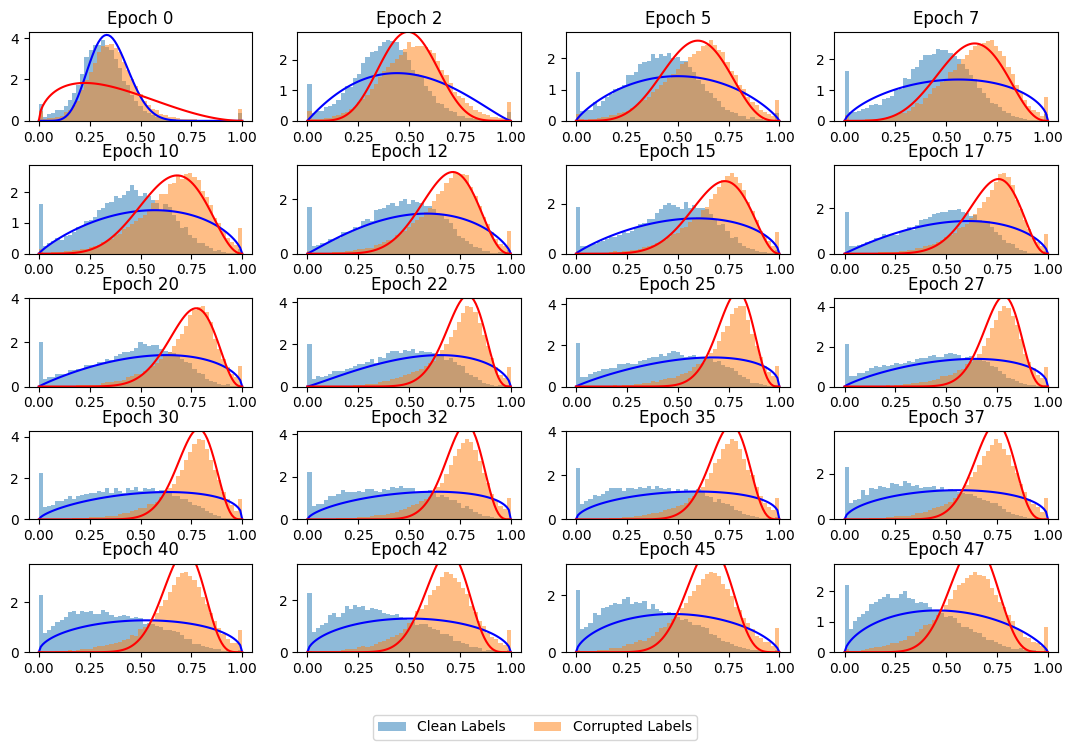

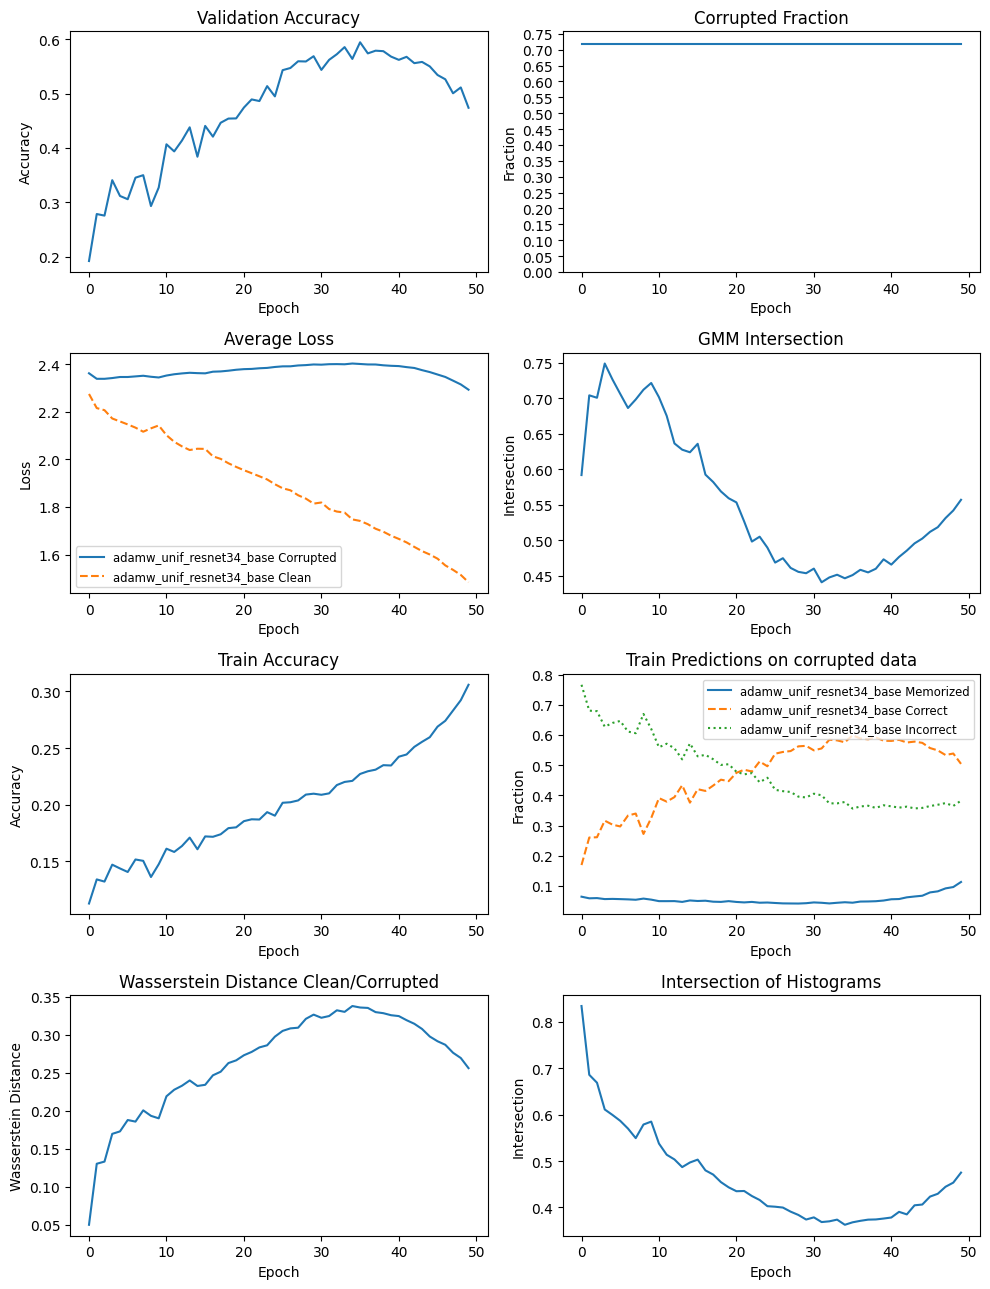

In [114]:
plot_insights('adamw_unif_resnet34_base')

Processing adamw_unif_resnet34_selc:   0%|          | 0/155 [00:00<?, ?it/s]

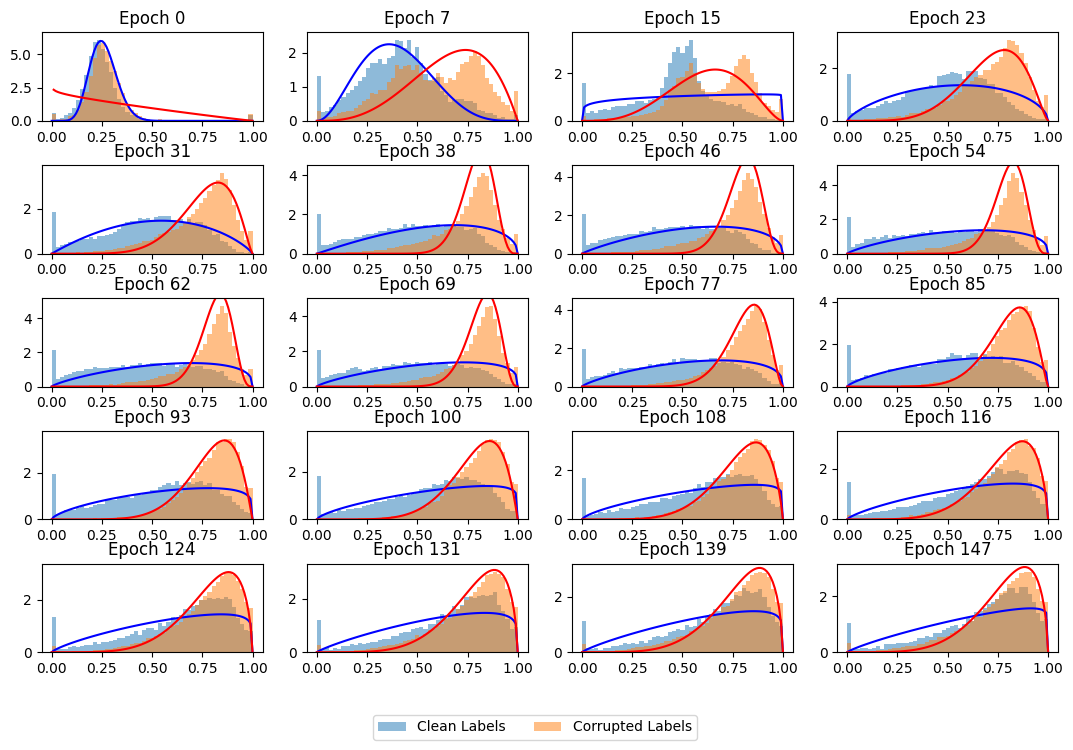

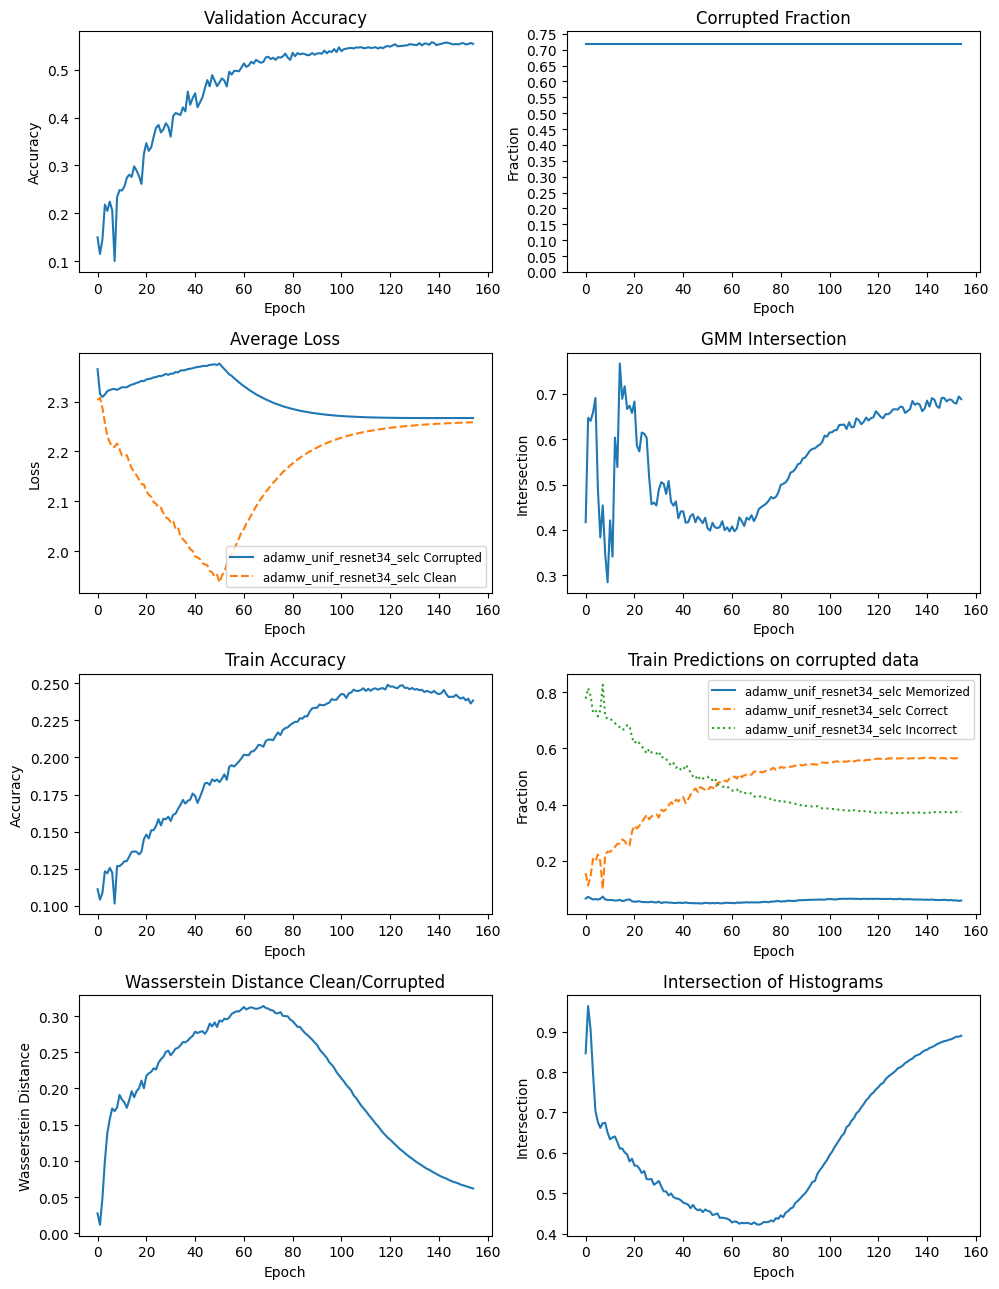

In [117]:
plot_insights('adamw_unif_resnet34_selc')

Processing adamw_unif_resnet34_weights_inv:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_627725/2431876221.py:97: RuntimeWarning: invalid value encountered in scalar divide
  gmm_intersection = np.sum(np.minimum(pdf1, pdf2)) / sum_pdf1 if sum_pdf1 > 1e-9 else np.nan


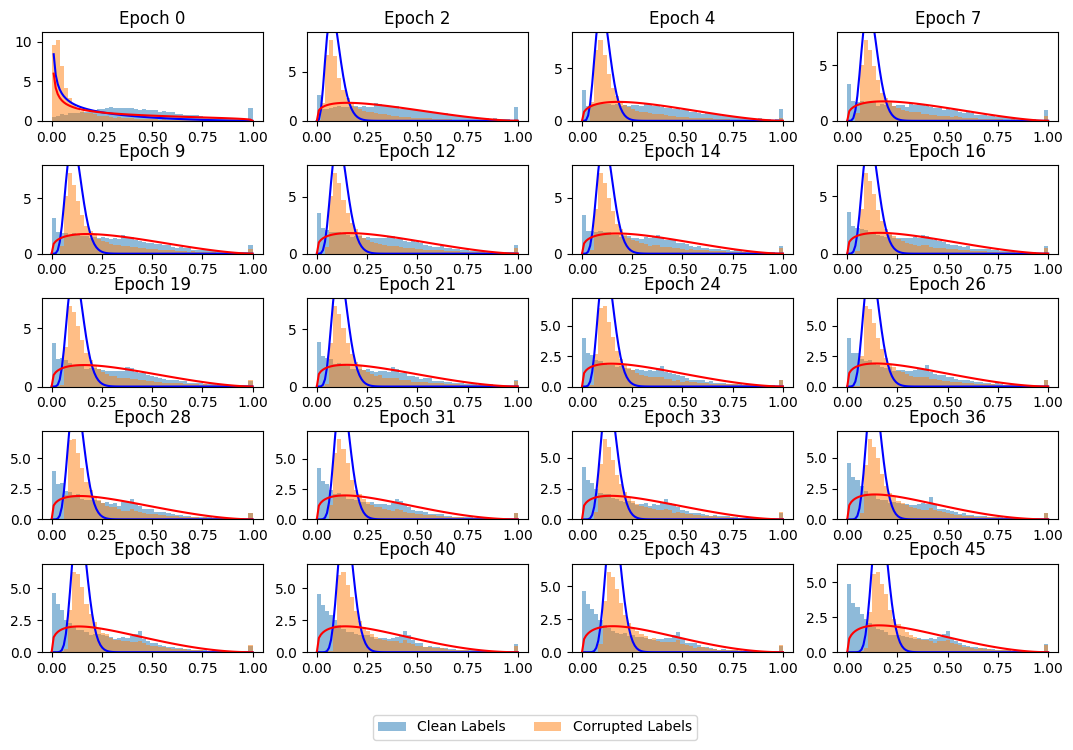

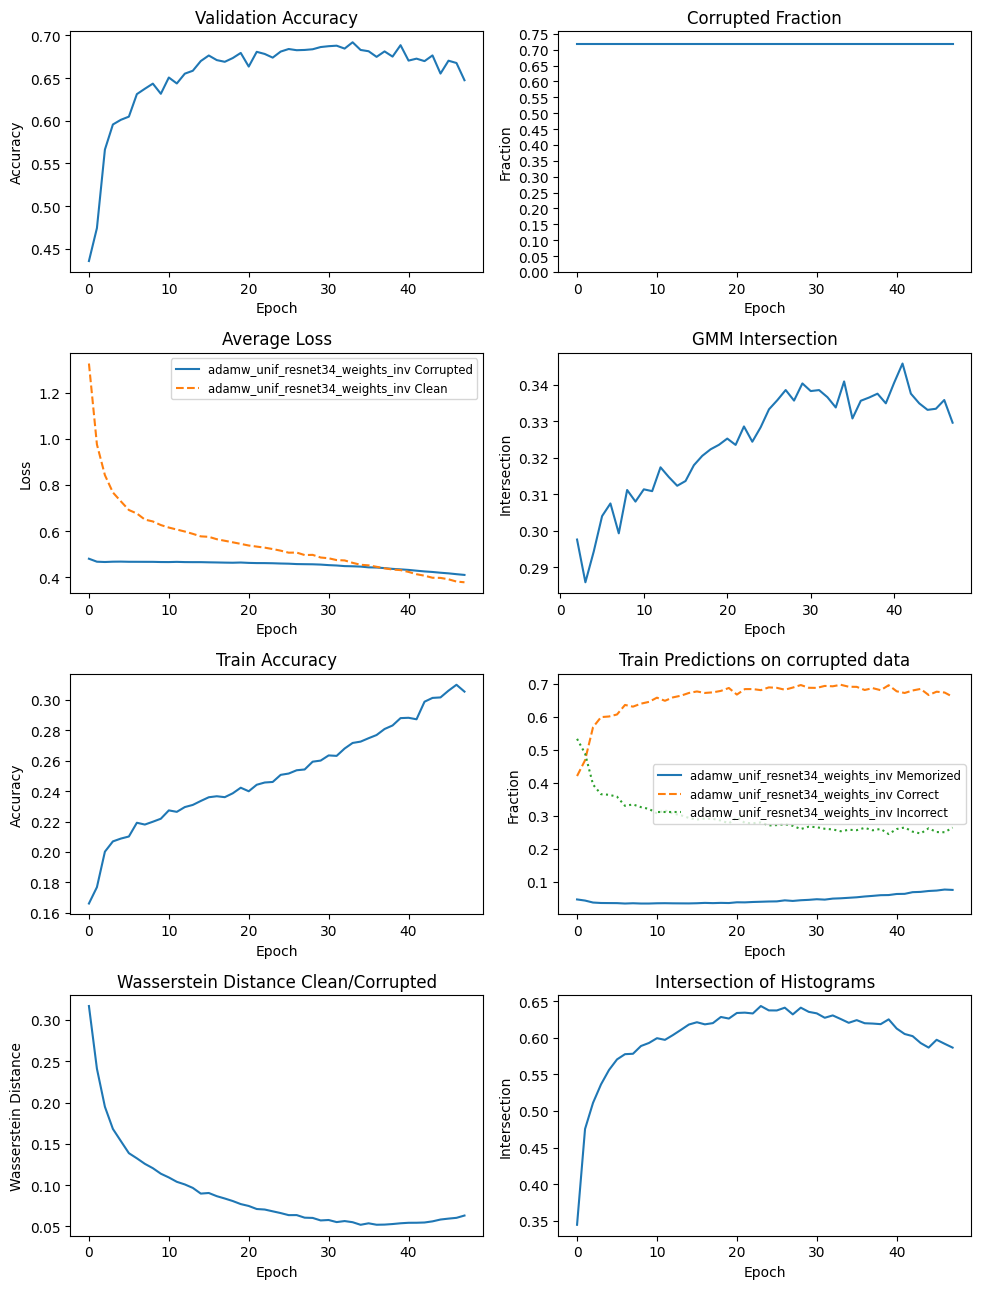

In [4]:
plot_insights('adamw_unif_resnet34_weights_inv')

Processing adamw_unif_resnet34_weights_discard:   0%|          | 0/52 [00:00<?, ?it/s]

/tmp/ipykernel_627725/2431876221.py:97: RuntimeWarning: invalid value encountered in scalar divide
  gmm_intersection = np.sum(np.minimum(pdf1, pdf2)) / sum_pdf1 if sum_pdf1 > 1e-9 else np.nan


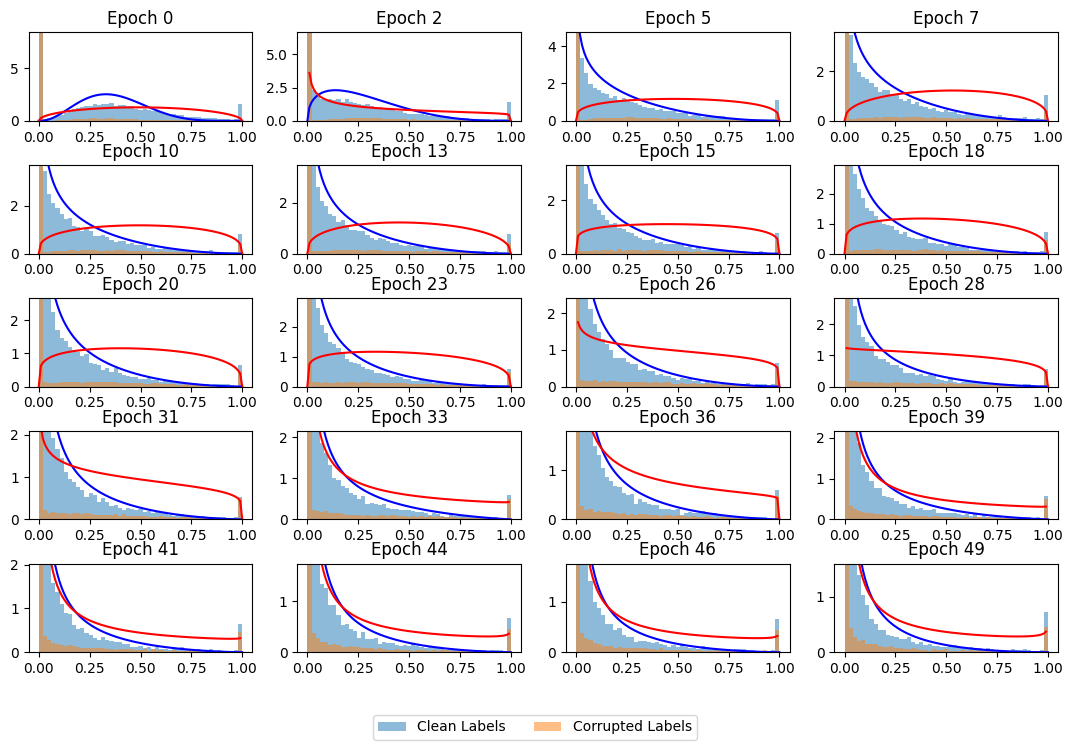

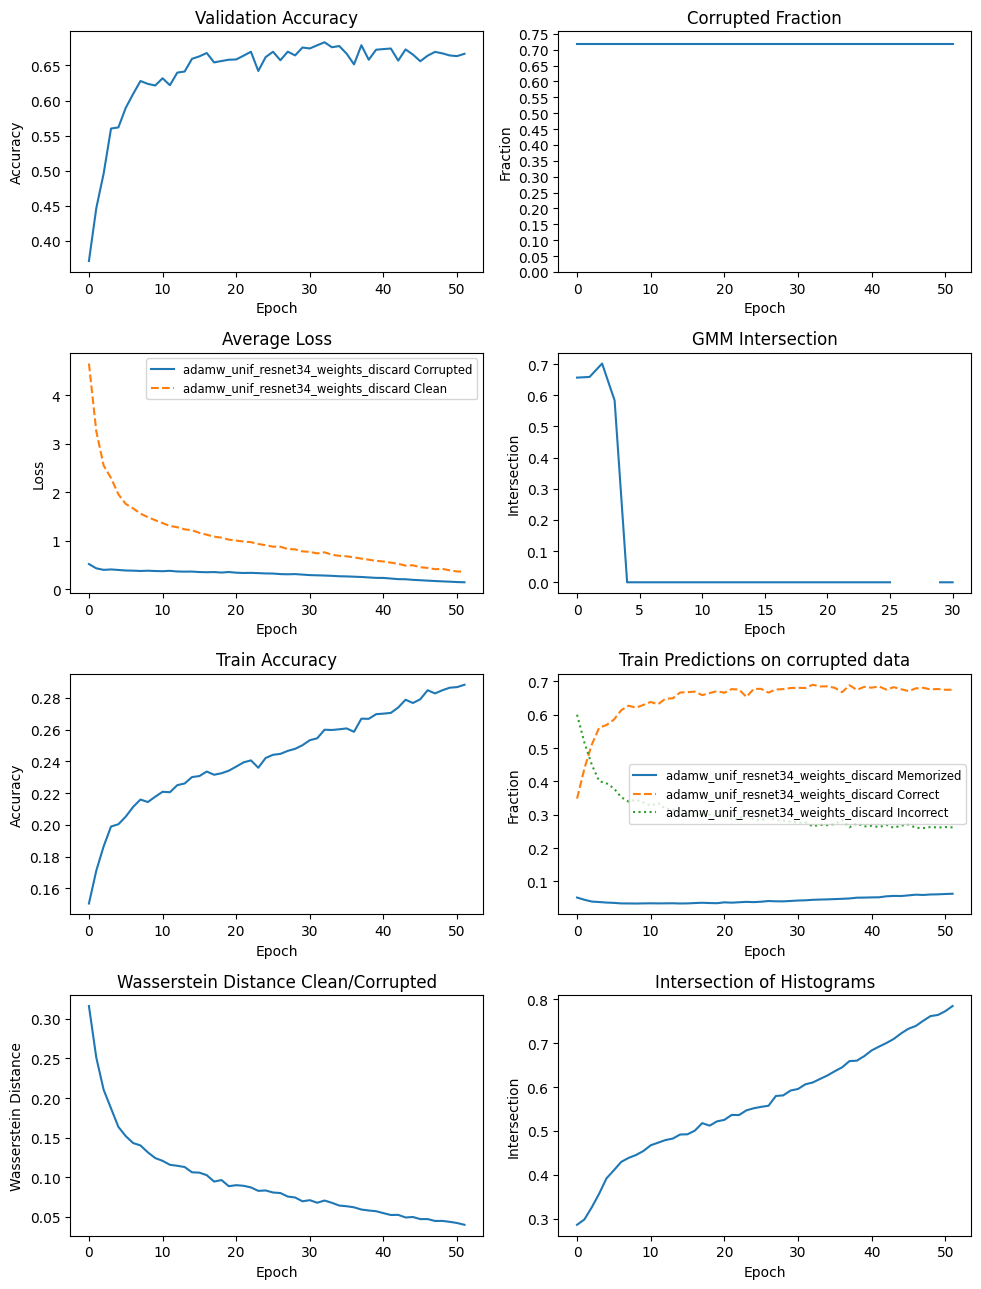

In [6]:
plot_insights('adamw_unif_resnet34_weights_discard')